# MIBC multiclass classifier

### Outlines:

##### 1-Data wrangling

##### 2-Making decision tree classifier

##### 3- Classifier prediction on the train set

##### 4- Classifier prediction on the test set

##### 5- Visualization

##### 6- Feature importance

##### 7- multiclass AUC curve analysis & plots

_____________________________________________________________________________________________________________________________________________

### 1- Data wrangling

The data set that Iused for this job is coming from Sjödahl et.al J Pathol 2017; 242: 113–125. 

In [54]:
# Import libraries
import numpy as np
import pandas as pd
import os as os 

In [55]:
os.getcwd()
#'C:\\Users\\qaedi'
os.chdir("C://Users/qaedi/Documents/")



In [56]:
data = pd.read_csv("C://Users/qaedi/Desktop/Lund_reverse_validation/4.JPath2017_PtLevel.csv")
data.head()

,TMA#,Age,Sex,Grade,Stage,Clinical stage,Hyb#,Subtype_LundTax_RNA,Subtype_IHC,CK5_Pattern_Bernardo,...,PPARG,pSTAT3,RB1,RXRA,SYP,TP63,TUBB2B,UPK3,VIM,ZEB2
0,3,74.0,Female,G3,pT2,T4a,91.0,Ba/Sq,BaSq,all,...,0.0,1.80,9.0,0.8,0.0,9.0,2.0,0.0,1.35,0.0
1,7,75.6,Male,G2,pT2,T3,54.0,Ba/Sq,BaSq,all,...,0.0,1.35,0.0,0.5,0.0,9.0,1.0,0.0,0.00,1.0
2,29,72.1,Female,G3,pT2,T2,208.0,Ba/Sq,BaSq,all,...,0.0,1.65,0.0,0.0,0.0,9.0,0.5,0.0,0.05,0.0
3,39,55.3,Female,G3,pT2,T2,25.0,Ba/Sq-Inf,Uro,ML,...,1.6,0.55,9.0,0.7,0.0,8.0,0.0,0.0,0.30,0.0
4,55,75.5,Female,G3,pT2,T2,24.0,Ba/Sq-Inf,BaSq,all,...,0.0,1.80,9.0,0.0,0.0,9.0,0.5,0.0,0.70,0.0


In [57]:
#data.describe()

In [58]:


# Review missing data in the demographic information
#print(data.isnull().sum())



In [59]:
# dropping NAs from Subtype_IHC
data = data.dropna(subset=['Subtype_IHC'])
print(data.isnull().sum())


TMA#                      0
Age                       0
Sex                       0
Grade                     4
Stage                     1
Clinical stage           27
Hyb#                    102
Subtype_LundTax_RNA     102
Subtype_IHC               0
CK5_Pattern_Bernardo    152
CCNB1                     2
CCND1                     0
CD3density                0
CD68density               0
CDH1                      0
CDH3                      1
CDKN2Ap16                 0
CHGA                      1
E2F3                      1
EGFR                      2
EPCAM                     0
ERBB2                     0
ERBB3                     0
FGFR3                     0
FOXA1                     0
FOXM1                     1
GATA3                     0
KRT14                     0
KRT20                     4
KRT5                      0
NCAM1                     0
PPARG                     0
pSTAT3                    0
RB1                       0
RXRA                      0
SYP                 

In [60]:
#print(data.shape)

In [61]:
# slicing based on columns
d = data.iloc[:, 10:41]

# imputing missing values by mean of columns
d.fillna(d.mean(), inplace = True)

#print(d.isnull().sum())


In [62]:
# replace a part of data farme by othe dataframe
data.iloc[:, 0:9]

data = pd.concat([data.iloc[:, 0:9], d], axis=1)

#print(data.isnull().sum())

In [63]:
# drop values from subtype_IHC column
data = data.drop(data[(data['Subtype_IHC'] == 'Mes-L') | (data['Subtype_IHC'] == 'Sc/NE')].index)
print(data.Subtype_IHC.value_counts())


Uro     195
GU      109
BaSq     57
Name: Subtype_IHC, dtype: int64


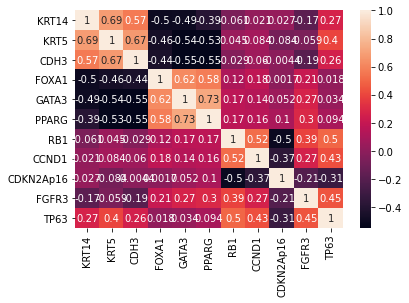

In [64]:
# feature selection based on ROC analysis:
## KRT14, KRT5, CDH3, FOXA1, GATA3, PPARG for Uro vs. Bas
## RB1 , CCND1, CDKN2Ap16, FGFR3

corrmat = data[["Subtype_IHC", "KRT14", "KRT5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "CDKN2Ap16", "FGFR3", "TP63"]].corr()

# visualization 
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrmat, annot=True)
plt.show()

_____________________________________________________________________________________________________________________________________________

### 2-Making decision tree classifier

In [84]:
X = data[["KRT14", "KRT5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "CDKN2Ap16", "FGFR3", "TP63"]].values
y = data.iloc[:,8].values
# codes; 0 = BaSq, 1 = Uro, 2 = GU


In [85]:
# encode IHC subtype as a dummy variable
y,class_names = pd.factorize(y)


In [86]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

In [87]:
# Fitting Classifier to the Training Set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

_____________________________________________________________________________________________________________________________________________

### 3-Classifier prediction on the train set


In [88]:
# Model performance on training set
y_pred_train =classifier.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train))

Accuracy: 0.93
Confusion Matrix: 
 [[ 37   6   0]
 [  0 146   0]
 [  0  14  67]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        43
           1       0.88      1.00      0.94       146
           2       1.00      0.83      0.91        81

    accuracy                           0.93       270
   macro avg       0.96      0.90      0.92       270
weighted avg       0.93      0.93      0.93       270



_____________________________________________________________________________________________________________________________________________

### 4-Classifier prediction on the test set


In [70]:
y_pred=classifier.predict(X_test)

# Classification results on test set
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred))

Accuracy: 0.86
Confusion Matrix: 
 [[10  3  1]
 [ 0 49  0]
 [ 1  8 19]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.82      1.00      0.90        49
           2       0.95      0.68      0.79        28

    accuracy                           0.86        91
   macro avg       0.89      0.80      0.83        91
weighted avg       0.87      0.86      0.85        91



_____________________________________________________________________________________________________________________________________________

### 5-Visualization

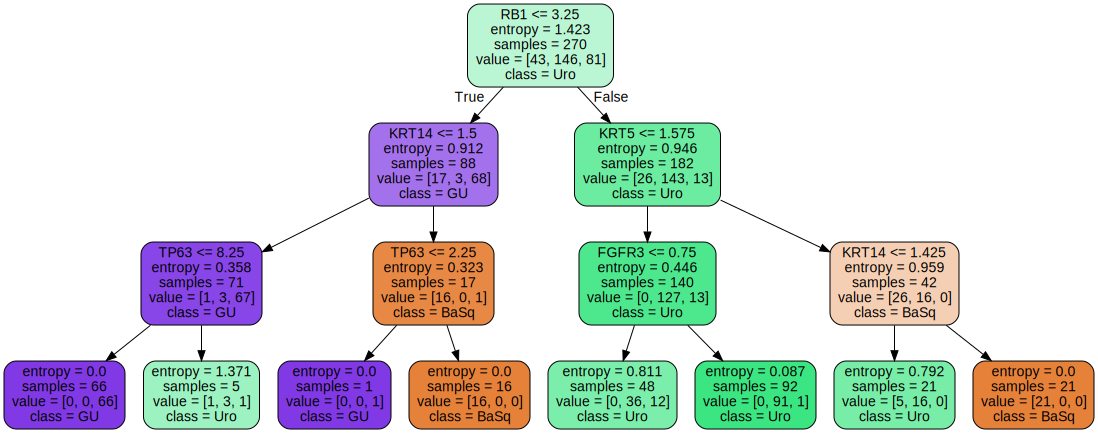

In [71]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
from IPython.display import Image
from IPython.display import Image  

feature_names = ["KRT14", "KRT5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "CDKN2Ap16", "FGFR3", "TP63"]
dot_data = tree.export_graphviz(classifier, out_file=None, filled=True,feature_names = feature_names, rounded = True, class_names=class_names)
graph = graphviz.Source(dot_data)
graph
#graph.render('round-table.pdf', view=True)  

_____________________________________________________________________________________________________________________________________________

### 6- Feature importance


In [74]:
importances = pd.DataFrame({'feature':feature_names,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
6,RB1,0.416
0,KRT14,0.335
9,FGFR3,0.077
10,TP63,0.039
1,KRT5,0.035
5,PPARG,0.035
8,CDKN2Ap16,0.028
4,GATA3,0.023
2,CDH3,0.012
3,FOXA1,0.000


_____________________________________________________________________________________________________________________________________________

### 7- multiclass AUC curve analysis & plots


In [75]:
import matplotlib.pyplot as plt
from itertools import cycle
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.tree import DecisionTreeClassifier

df = data
print(df.Subtype_IHC.value_counts())
#________________this code chunk do the job but reset categorical variable level________#
# create a column to encode Subtype_IHC to numerical 
#df.Subtype_IHC = pd.Categorical(df.Subtype_IHC)
#df['target'] = df.Subtype_IHC.cat.codes

X = df[["KRT14", "KRT5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "CDKN2Ap16", "FGFR3", "TP63"]].values
y = data.Subtype_IHC.values
print('X data looks like', X[0:10])
print('y data looks like', y[0:10])
print('X data type is', type(X))
print('y data type is', type(y))
print('X dimention is', X.shape)
print('y dimention is', y.shape)


# Binarize the output
y,class_names = pd.factorize(y)
print(y[1:20])
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]



Uro     195
GU      109
BaSq     57
Name: Subtype_IHC, dtype: int64
X data looks like [[2.7  2.7  2.7  1.   0.15 0.   9.   2.7  1.   2.   9.  ]
 [0.   2.7  1.6  0.   0.85 0.   0.   0.   3.   1.5  9.  ]
 [2.7  2.7  2.7  0.   0.   0.   0.   0.   1.5  0.   9.  ]
 [0.05 1.8  1.8  3.   2.25 1.6  9.   2.4  0.5  1.   8.  ]
 [2.7  2.25 2.25 0.5  0.6  0.   9.   1.3  1.   0.   9.  ]
 [2.7  2.7  2.4  0.   0.1  0.   0.   0.05 1.5  0.5  9.  ]
 [0.15 0.   0.7  3.   2.55 2.7  9.   1.5  2.   2.   8.  ]
 [2.7  0.9  2.25 0.   0.45 0.   0.   0.65 3.   0.   7.5 ]
 [0.15 1.05 1.95 1.5  0.75 0.4  8.   0.35 2.   0.5  7.  ]
 [2.7  2.7  0.7  0.   0.   0.   7.   0.5  0.   0.   8.  ]]
y data looks like ['BaSq' 'BaSq' 'BaSq' 'Uro' 'BaSq' 'BaSq' 'Uro' 'BaSq' 'GU' 'BaSq']
X data type is <class 'numpy.ndarray'>
y data type is <class 'numpy.ndarray'>
X dimention is (361, 11)
y dimention is (361,)
[0 0 1 0 0 1 0 2 0 1 0 1 2 0 1 0 0 0 0]


In [76]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

print(type(y))

# 
classifier_2 = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42))
y_score = classifier_2.fit(X_train, y_train).predict_proba(X_test)

<class 'numpy.ndarray'>


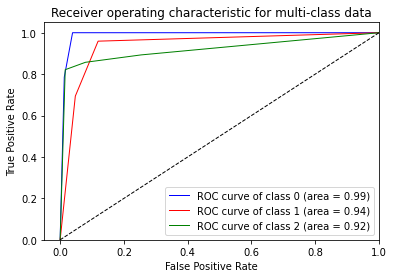

In [77]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
lw = 1
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

_____________________________________________________________________________________________________________________________________________

## Classifier with reduced features

In order to make classifiers to work on NMIBC dataset like Sjödahl et al. Int. J. Cancer: 146, 2636–2647 (2019), the classifiers should be modified in the way that they work with common features between the two dataset.Since both dataset are coming from the same laboratory the classifres should work on NMIBC dataset without serious biases like those arising from data preparation.

Subtypes of samples in the NMIBC data  set is as follows:
    
    Ba/Sq    GU      Mes Sc/NE   Uro 
    8         55     7     6     192 

Common features between NMIBC dataset and the selected markers of MIBC:

"CCND1","CDKN2Ap16","FGFR3","FOXA1","GATA3","KRT14","KRT5","RB1"  

Here first I will rebuild the MIBC classifiers based on the common features with NMIBC, then the NMIBC data set will be feed to the classifiers as  validation dataset.

______________________________________________________________________________________________________________________________________________